<a href="https://colab.research.google.com/github/praths007/tensorflow_certification/blob/master/coursera_practise/TS_week4_sun_spots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import tensorflow as tf

In [89]:
tf.__version__

'2.3.0'

In [90]:
import csv
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda

In [91]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-19 12:16:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-08-19 12:16:48 (3.19 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [92]:
timestamp = []
magnitude = []
with open('/tmp/daily-min-temperatures.csv', 'r') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)
  for row in reader:
    timestamp.append(row[0])
    magnitude.append(float(row[1]))

In [93]:
len(magnitude)

3650

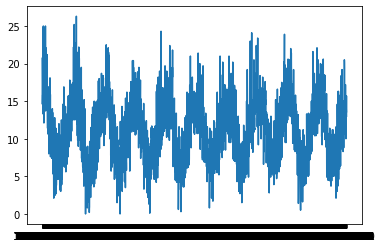

In [94]:
import matplotlib.pyplot as plt
plt.plot(timestamp, magnitude)

In [105]:
# small window size is helpful
# small buffer size is good
batch_size = 64
window_size = 5
buffer_shuffle_size = 16
train_size = int(len(timestamp)*0.8)


In [106]:
train_x = magnitude[:train_size]
train_time = timestamp[:train_size]
test_x = magnitude[train_size:]
test_time = timestamp[train_size:]

In [107]:
def window_dataset(series, window_size, shuffle_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_size).map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [108]:
tf.keras.backend.clear_session()

dataset = window_dataset(train_x, window_size, buffer_shuffle_size, batch_size)

model = Sequential([
                    Lambda(lambda x: tf.expand_dims(x, -1), input_shape=[None]),
                    Bidirectional(LSTM((64), return_sequences=True)),
                    Bidirectional(LSTM(64)),
                    Dense(64, activation='relu'),
                    Dense(1),
                    Lambda(lambda x:x*100.0)
])

In [109]:
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
history = model.fit(dataset, epochs=100)

Epoch 1/100
46/46 [==============================] - 1s 13ms/step - loss: 6.2319 - mae: 6.7097
Epoch 2/100
46/46 [==============================] - 1s 13ms/step - loss: 2.6572 - mae: 3.1254
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: 1.9160 - mae: 2.3673
Epoch 4/100
46/46 [==============================] - 1s 14ms/step - loss: 2.0813 - mae: 2.5389
Epoch 5/100
46/46 [==============================] - 1s 13ms/step - loss: 1.6898 - mae: 2.1393
Epoch 6/100
46/46 [==============================] - 1s 15ms/step - loss: 1.8103 - mae: 2.2590
Epoch 7/100
46/46 [==============================] - 1s 13ms/step - loss: 1.7805 - mae: 2.2329
Epoch 8/100
46/46 [==============================] - 1s 14ms/step - loss: 1.7681 - mae: 2.2209
Epoch 9/100
46/46 [==============================] - 1s 14ms/step - loss: 1.6968 - mae: 2.1468
Epoch 10/100
46/46 [==============================] - 1s 13ms/step - loss: 1.6530 - mae: 2.1010
Epoch 11/100
46/46 [=============================

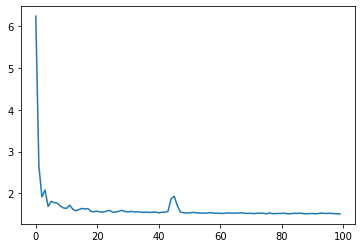

In [110]:
plt.plot(history.history['loss'])

In [111]:
forecast = []
for time in range(len(magnitude) - window_size):
  forecast.append(model.predict(magnitude[time:(time+window_size)]))

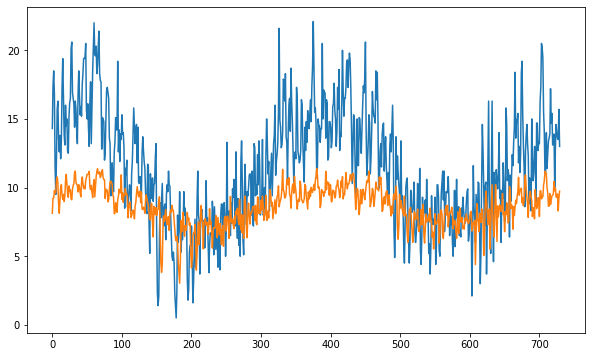

In [112]:
forecast = forecast[train_size-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(test_x)
plt.plot(results)

In [113]:
tf.metrics.mae(results, test_x)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5554447>